# Create and Test a Model-Serving Nuclio Function

This notebook demonstrates how to write an inference server, test it, and turn it into an auto-scaling Nuclio serverless function.

- [Initialize Nuclio Emulation, Environment Variables, and Configuration](#image-class-infer-init-func)
- [Create and Load the Model and Set Up the Function Handler](#image-class-infer-create-n-load-model-n-set-up-func-handler)
- [Trigger the Function](#image-class-infer-func-trigger)
- [Prepare to Deploy the Function](#image-class-infer-func-deploy-prepare)
- [Deploy the Function](#image-class-infer-func-deploy)
- [Test the Function](#image-class-infer-func-test)

<a id="image-class-infer-init-func"></a>
## Initialize Nuclio Emulation, Environment Variables, and Configuration

> **Note:** Use `# nuclio: ignore` for sections that don't need to be copied to the function.

In [1]:
# nuclio: ignore
import nuclio
import random
import matplotlib.pyplot as plt

In [12]:
%%nuclio env
IMAGE_WIDTH = 128
IMAGE_HEIGHT = 128
version = 1.0

%nuclio: setting 'IMAGE_WIDTH' environment variable
%nuclio: setting 'IMAGE_HEIGHT' environment variable
%nuclio: setting 'version' environment variable


In [13]:
%nuclio env -c MODEL_PATH=/model/
%nuclio env -l MODEL_PATH=./model/

%nuclio: setting 'MODEL_PATH' environment variable


In [14]:
%%nuclio cmd -c
pip install git+https://github.com/fchollet/keras
pip install tensorflow 
pip install numpy
pip install requests
pip install pillow

In [15]:
%%nuclio config 
spec.build.baseImage = "python:3.6-jessie"

%nuclio: setting spec.build.baseImage to 'python:3.6-jessie'


In [16]:
%nuclio mount /model ~/image-classification/cats_dogs/model

mounting volume path /model as ~/image-classification/cats_dogs/model


<a id="image-class-infer-create-n-load-model-n-set-up-func-handler"></a>
## Create and Load the Model and Set Up the Function Handler

In [17]:
import numpy as np 
from tensorflow import keras
from keras.models import load_model
from keras.preprocessing import image
from keras.preprocessing.image import load_img
import json
import requests

import os
from os import environ, path
from tempfile import mktemp

In [18]:
model_file = environ['MODEL_PATH'] + 'cats_dogs.hd5'
prediction_map_file = environ['MODEL_PATH'] + 'prediction_classes_map.json'

# Set image parameters
IMAGE_WIDTH = int(environ['IMAGE_WIDTH'])
IMAGE_HEIGHT = int(environ['IMAGE_HEIGHT'])

# load model
def init_context(context): 
    context.model = load_model(model_file)
    with open(prediction_map_file, 'r') as f:
        context.prediction_map = json.load(f)

In [19]:
def download_file(context, url, target_path):
    with requests.get(url, stream=True) as response:
        response.raise_for_status()
        with open(target_path, 'wb') as f:
            for chunk in response.iter_content(chunk_size=8192):
                if chunk:
                    f.write(chunk)

    context.logger.info_with('Downloaded file',url=url)

In [20]:
def handler(context, event):
    tmp_file = mktemp()
    image_url = event.body.decode('utf-8').strip()
    download_file(context, image_url, tmp_file)
    
    img = load_img(tmp_file, target_size=(IMAGE_WIDTH, IMAGE_HEIGHT))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)

    images = np.vstack([x])
    predicted_probability = context.model.predict_proba(images, batch_size=10)
    predicted_class = list(zip(predicted_probability, map(lambda x: '1' if x >= 0.5 else '0', predicted_probability)))
    actual_class = [(context.prediction_map[x[1]],x[0][0]) for x in predicted_class]   
    os.remove(tmp_file)
    result = {'class':actual_class[0][0], 'dog-probability':float(actual_class[0][1])}
    return json.dumps(result)

<a id="image-class-infer-func-trigger"></a>
## Trigger the Function

In [21]:
# nuclio: ignore
init_context(context)

Python> 2019-03-25 11:50:51,168 [info] Downloaded file: {'url': 'https://s3.amazonaws.com/iguazio-sample-data/images/catanddog/dog.241.jpg'}
{"class": "dog", "dog-probability": 1.0}


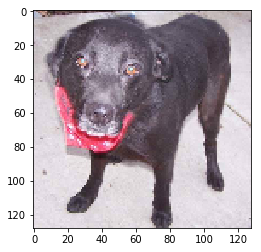

In [22]:
# nuclio: ignore
# Select a sample for the test.
# Set both the local path for the test and the URL for downloading the sample from AWS S3.
DATA_LOCATION = "./cats_and_dogs_filtered/"
sample = random.choice(os.listdir(DATA_LOCATION+"/cats_n_dogs"))
image_local = DATA_LOCATION + "cats_n_dogs/"+sample # Temporary location for downloading the file 
image_url = 'https://s3.amazonaws.com/iguazio-sample-data/images/catanddog/' + sample 

# Show the image
img = load_img(image_local, target_size=(IMAGE_WIDTH, IMAGE_HEIGHT))
plt.imshow(img)

event = nuclio.Event(body=bytes(image_url, 'utf-8'))
output = handler(context, event)
print(output)

In [24]:
%nuclio show

%nuclio: notebook exported to /tmp/tmpzj2aeznv/infer.yaml
Code:
# Generated by nuclio.export.NuclioExporter on 2019-03-25 11:51

import numpy as np 
from tensorflow import keras
from keras.models import load_model
from keras.preprocessing import image
from keras.preprocessing.image import load_img
import json
import requests

import os
from os import environ, path
from tempfile import mktemp

model_file = environ['MODEL_PATH'] + 'cats_dogs.hd5'
prediction_map_file = environ['MODEL_PATH'] + 'prediction_classes_map.json'

IMAGE_WIDTH = int(environ['IMAGE_WIDTH'])
IMAGE_HEIGHT = int(environ['IMAGE_HEIGHT'])

def init_context(context): 
    context.model = load_model(model_file)
    with open(prediction_map_file, 'r') as f:
        context.prediction_map = json.load(f)

def download_file(context, url, target_path):
    with requests.get(url, stream=True) as response:
        response.raise_for_status()
        with open(target_path, 'wb') as f:
            for chunk in response.iter_conten

<a id="image-class-infer-func-deploy-prepare"></a>
## Prepare to Deploy the Function

Before you deploy the function, open a Jupyter terminal and run the following command:

`pip install --upgrade nuclio-jupyter`

<a id="image-class-infer-func-deploy"></a>
## Deploy the Function

Run the following command to deploy the function:

In [ ]:
%nuclio deploy -n cats-dogs -p ai -c

<a id="image-class-infer-func-test"></a>
## Test the Function

In [ ]:
# Run a test with the new function. Replace the "function URL:port" with the actual URL and port number.
# To get the function's URL, in the platform dashboard navigate to the function page -
# Functions> ai > cats-dogs - and select the Status tab.
!curl -X POST -d "https://s3.amazonaws.com/iguazio-sample-data/images/catanddog/cat.123.jpg" <function URL:port> 